# Improve eddy tracking

The objective of this script is to improve the eddy tracking and remove all the bugs found in the first stage of development. 

In [1]:
# Importing all libraries except trackeddy.
from pylab import *
from netCDF4 import Dataset
%matplotlib inline
import os
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
import time

In [2]:
# Output data path
outputpath='/g/data/v45/akm157/model_output/mom/mom01v5_kds75/output306/'
# Import SSH values to python environment.
ncfile=Dataset(outputpath+'rregionsouthern_ocean_daily_eta_t.nc')
eta=ncfile.variables['eta_t'][:]*100
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['xt_ocean_sub01'][:]
lat=ncfile.variables['yt_ocean_sub01'][:]

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: SSH mean of the Southern Ocean over 10 years
    history: Created 31/07/17
    dimensions(sizes): lon(3600), lat(931), time(1)
    variables(dimensions): float32 Longitude(lon), float32 Latitude(lat), int32 Time(time), float32 SSH_mean(time,lat,lon)
    groups: 

(931, 3600)


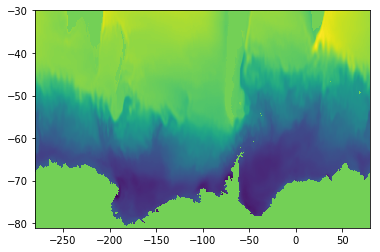

In [3]:
# Import SSH values to python environment.
ncfile=Dataset('/home/156/jm5970/notebooks/traceddy/data.output/meanssh_10yrs_AEXP.nc')
print ncfile

ssh_mean=squeeze(ncfile.variables['SSH_mean'][:])
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['Longitude'][:]
lat=ncfile.variables['Latitude'][:]
print shape(ssh_mean)
## CHANGE FUNCTION TO PLOT
pcolormesh(lon,lat,ssh_mean)

In [4]:
###This mask is necessary to remask each time step, 
#It's not necesary if your mask is good in all the time steps
mask=ma.getmask(eta[0,:,:])

## Possitive eddy tracking

In [5]:
#Area in indexes, probably in the future it will be added an option for lon - lat coords.
areamap=array([[0,len(lon)],[0,len(lat)]])
#Levels to Analyse, note that one of them is an extreme value,
#This is because we don't want interference from any other contour.
# If you want to Analyse multiple levels, please go to the Moving in Z section.
levels=[10,500]
for ii in range(0,1):
    print '*****************',ii,'*****************'
    ssha=eta[ii,:,:]-ssh_mean
    eddys=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
    if ii==0:
        eddytd=dict_eddyt(ii,eddys)
    else:
        eddytd=dict_eddyt(ii,eddys,eddytd) 


***************** 0 *****************


/home/156/jm5970/notebooks/traceddy/trackeddy/tracking.py:90: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask!='':


[10, 500]
The total of contours was 409
('ts', 0)


## Negative eddy tracking

In [6]:
levels=[-500,-10]
for ii in range(0,1):
    print '*****************',ii,'*****************'
    ssha=eta[ii,:,:]-ssh_mean
    eddys=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
    if ii==0:
        eddytdn=dict_eddyt(ii,eddys)
    else:
        eddytdn=dict_eddyt(ii,eddys,eddytd) 

***************** 0 *****************
[-500, -10]
The total of contours was 320
('ts', 0)


## Removing eddies from eddy field or any other variable.

In [7]:
#This threshold will let you grow the domine around the eddy contour.
threshold=1
# Function that removes the eddies
## Positive remotion
eddysplot=exeddy(eddytd,lat,lon,ssha,0,threshold,diagnostics=False)

*********Removing  eddyn_249 *******
26.402
*********Removing  eddyn_237 *******
16.2413
*********Removing  eddyn_236 *******
10.5032
*********Removing  eddyn_235 *******
18.0361
*********Removing  eddyn_234 *******
13.7809
*********Removing  eddyn_233 *******
10.5884
*********Removing  eddyn_232 *******
38.3216
*********Removing  eddyn_231 *******
50.7219
*********Removing  eddyn_230 *******
15.4799
*********Removing  eddyn_265 *******
22.361
*********Removing  eddyn_239 *******
14.2391
*********Removing  eddyn_238 *******
14.0684
*********Removing  eddyn_130 *******
29.7854
*********Removing  eddyn_131 *******
11.3734
*********Removing  eddyn_132 *******
11.7827
*********Removing  eddyn_133 *******
19.1593
*********Removing  eddyn_69 *******
12.5893
*********Removing  eddyn_68 *******
18.8332
*********Removing  eddyn_136 *******
12.7829
*********Removing  eddyn_137 *******
10.7525
*********Removing  eddyn_65 *******
11.1525
*********Removing  eddyn_64 *******
36.3335
*********Removin

*********Removing  eddyn_121 *******
28.9581
*********Removing  eddyn_194 *******
14.309
*********Removing  eddyn_195 *******
30.4458
*********Removing  eddyn_219 *******
20.7682
*********Removing  eddyn_218 *******
13.5373
*********Removing  eddyn_198 *******
35.6396
*********Removing  eddyn_120 *******
17.6954
*********Removing  eddyn_212 *******
17.1348
*********Removing  eddyn_151 *******
12.4544
*********Removing  eddyn_118 *******
14.6258
*********Removing  eddyn_119 *******
11.1233
*********Removing  eddyn_112 *******
10.4064
*********Removing  eddyn_113 *******
11.3665
*********Removing  eddyn_110 *******
12.2259
*********Removing  eddyn_111 *******
18.7431
*********Removing  eddyn_116 *******
13.8506
*********Removing  eddyn_117 *******
13.4806
*********Removing  eddyn_114 *******
12.4255
*********Removing  eddyn_115 *******
12.6633
*********Removing  eddyn_47 *******
15.0362
*********Removing  eddyn_46 *******
11.6187
*********Removing  eddyn_45 *******
14.9277
*********Remov

In [8]:
## Negative remotion
eddysplotn=exeddy(eddytdn,lat,lon,ssha,0,threshold,diagnostics=False)

*********Removing  eddyn_130 *******
-27.0204
*********Removing  eddyn_131 *******
-17.4509
*********Removing  eddyn_132 *******
-15.4379
*********Removing  eddyn_133 *******
-11.8417
*********Removing  eddyn_69 *******
-12.3538
*********Removing  eddyn_68 *******
-13.6323
*********Removing  eddyn_136 *******
-26.3975
*********Removing  eddyn_137 *******
-16.2042
*********Removing  eddyn_65 *******
-31.0187
*********Removing  eddyn_64 *******
-26.4922
*********Removing  eddyn_67 *******
-19.2548
*********Removing  eddyn_66 *******
-13.2336
*********Removing  eddyn_61 *******
-23.7177
*********Removing  eddyn_60 *******
-29.4646
*********Removing  eddyn_63 *******
-18.4016
*********Removing  eddyn_62 *******
-12.3096
*********Removing  eddyn_145 *******
-55.2344
*********Removing  eddyn_144 *******
-28.2354
*********Removing  eddyn_147 *******
-28.2901
*********Removing  eddyn_146 *******
-29.281
*********Removing  eddyn_141 *******
-12.1986
*********Removing  eddyn_140 *******
-18.6957

### Ploting removed data in beautiful maps

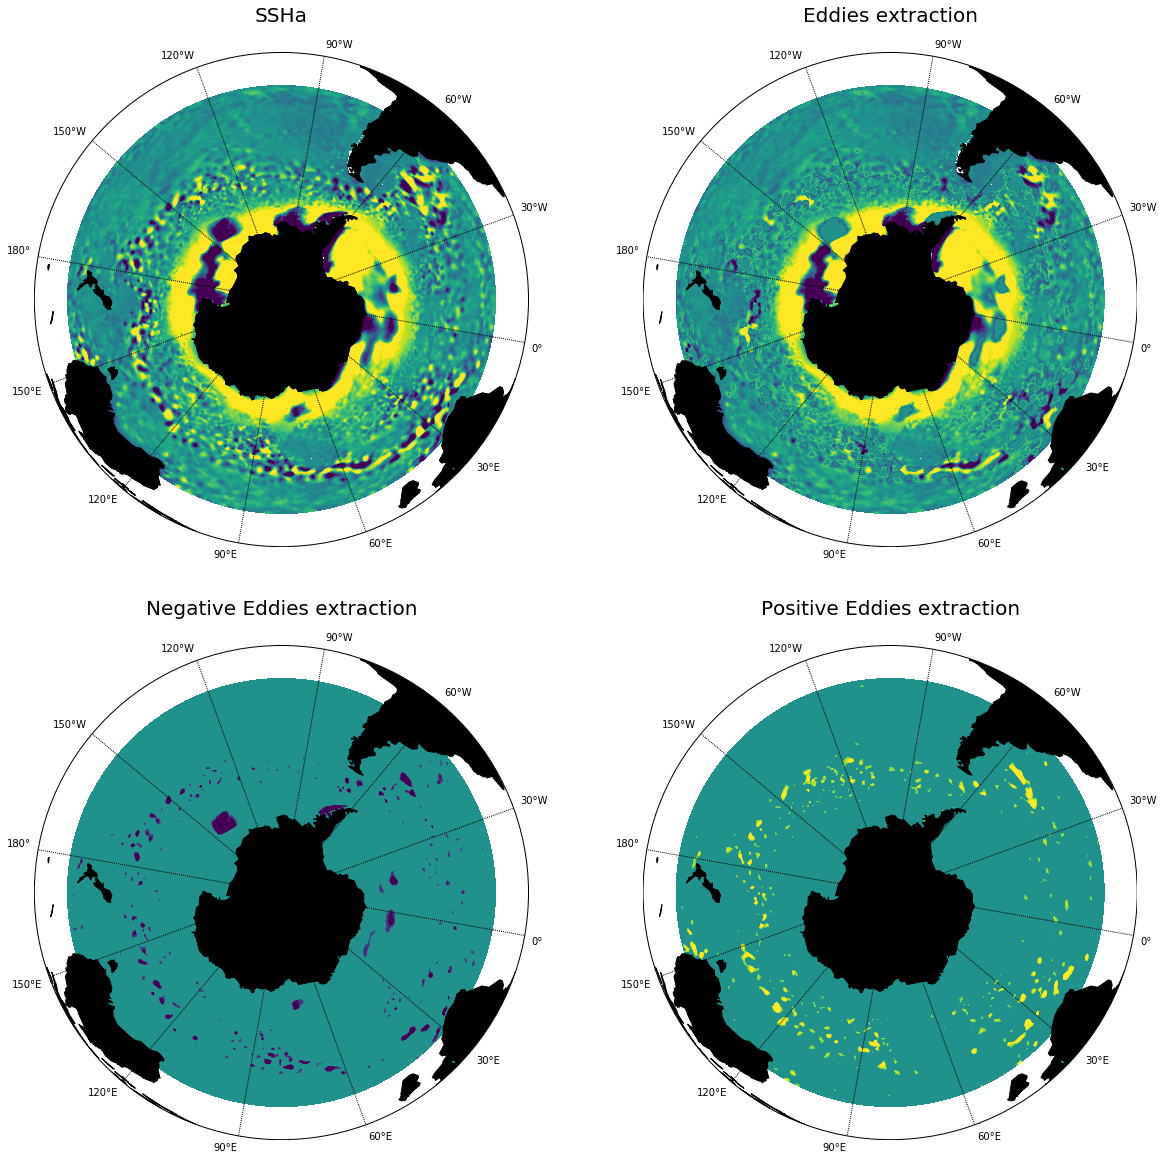

In [ ]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(2, 2, figsize=(20,20))

ttl=axes[0,0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0,0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0,0].pcolormesh(lonm,latm,ssha,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[0,1].set_title("Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0,1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0,1].pcolormesh(lonm,latm,ssha-eddysplot-eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[1,0].set_title("Negative Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1,0])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1,0].pcolormesh(lonm,latm,eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[1,1].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1,1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1,1].pcolormesh(lonm,latm,eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

plt.show()

# Moving in Z

In [ ]:
tic = time.clock()
areamap=array([[0,len(lon)],[0,len(lat)]])

mask=ma.getmask(eta[0,:,:])

minlevel=5
maxlevel=40
step=0.5
for ii in range(0,1):
    for ll in np.flipud(np.arange(minlevel-step,maxlevel+step,step)):
        levels=[ll,500]
        print '*****************',ii,ll,'*****************'
        ssha=eta[ii,:,:]-ssh_mean
        eddies=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
        #print eddies['Level']
        if ll == maxlevel:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,diagnostics=False)
        else:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,eddz,diagnostics=False)
    if ii==0:
        eddytd=dict_eddyt(ii,eddz)
    else:
        eddytd=dict_eddyt(ii,eddz,eddytd) 

toc = time.clock()
print toc-tic

***************** 0 40.0 *****************
[40.0, 500]
The total of contours was 46
('Level analized', 40.0)
***************** 0 39.5 *****************
[39.5, 500]
The total of contours was 46
('Level analized', 39.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
***************** 0 39.0 *****************
[39.0, 500]
The total of contours was 48
('Level analized', 39.0)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour 

[31.5, 500]
The total of contours was 88
('Level analized', 31.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
***************** 0 31.0 *****************
[31.0, 500]
The total of contours was 97
('Level analized', 31.0)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour 

[25.5, 500]
The total of contours was 123
('Level analized', 25.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
***************** 0 25.0 *****************
[25.0, 500]
The total of contours was 120
('Level analized', 25.0)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contou

[21.0, 500]
The total of contours was 163
('Level analized', 21.0)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Co

[17.5, 500]
The total of contours was 224
('Level analized', 17.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Co

[14.5, 500]
The total of contours was 268
('Level analized', 14.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Co

In [ ]:
threshold=1
pcolormesh(ssha)
plt.show()
eddysplot=exeddy(eddytd,lat,lon,ssha,0,threshold,diagnostics=False)

In [ ]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(1, 3, figsize=(20,20))

ttl=axes[0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0].pcolormesh(lonm,latm,ssha,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[1].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1].pcolormesh(lonm,latm,eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[2].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[2])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[2].pcolormesh(lonm,latm,ssha-eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

plt.show()

In [ ]:
tic = time.clock()
areamap=array([[0,len(lon)],[0,len(lat)]])

mask=ma.getmask(eta[0,:,:])

minlevel=-10
maxlevel=-30
step=-0.5
for ii in range(0,1):
    for ll in np.flipud(np.arange(minlevel,maxlevel+step,step)):
        levels=[-500,ll]
        print '*****************',ii,ll,'*****************'
        ssha=eta[ii,:,:]-ssh_mean
        eddies=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
        #print eddies['Level']
        if ll == maxlevel:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,diagnostics=False)
        else:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,eddz,diagnostics=False)
    if ii==0:
        eddytdn=dict_eddyt(ii,eddz)
    else:
        eddytdn=dict_eddyt(ii,eddz,eddytd) 

toc = time.clock()
print toc-tic

In [ ]:
threshold=1
pcolormesh(ssha)
plt.show()
eddysplotn=exeddy(eddytdn,lat,lon,ssha,0,threshold,diagnostics=False)

In [ ]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(1, 3, figsize=(20,20))

ttl=axes[0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0].pcolormesh(lonm,latm,ssha,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[1].set_title("Negative Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1].pcolormesh(lonm,latm,eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[2].set_title("Negative Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[2])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[2].pcolormesh(lonm,latm,ssha-eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

plt.show()

In [ ]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(2, 2, figsize=(20,20))

ttl=axes[0,0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0,0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0,0].pcolormesh(lonm,latm,ssha,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[0,1].set_title("Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0,1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0,1].pcolormesh(lonm,latm,ssha-eddysplot-eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[1,0].set_title("Negative Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1,0])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1,0].pcolormesh(lonm,latm,eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[1,1].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1,1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1,1].pcolormesh(lonm,latm,eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

fig.savefig('../output/eddy_removal.png', bbox_inches='tight')

plt.show()